In [1]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device is ", (device))

device is  cuda


In [2]:
def Lx2length(L_x, L_p, x1, x2, x3, h):
    l0, l1, l2, l3 = -x3, torch.sqrt((x2-x3)**2 + h**2), torch.sqrt((x1-x2)**2 + h**2), L_p+x1
    if L_x < -x3:
        l = L_x
    elif L_x < -x2:
        l = l0 + l1*(L_x + x3)/(x3-x2)
    elif L_x < -x1:
        l = l0 + l1 + l2*(L_x + x2)/(x2-x1)
    else:
        l = l0 + l1 + l2 + L_x+x1

    return l

def d2xy(d, L_p, x1, x2, x3, h):
    
    p0, p1, p2, p3 = torch.tensor([0.0,0.0]), torch.tensor([x3,0.0]), torch.tensor([x2, h]), torch.tensor([x1,0.0])
    v0, v1, v2, v3 = torch.tensor([x3-0,0.0]), torch.tensor([x2-x3,h]), torch.tensor([x1-x2,-h]), torch.tensor([-L_p-x1,0.0])
    l0, l1, l2, l3 = -x3, torch.sqrt((x2-x3)**2 + h**2), torch.sqrt((x1-x2)**2 + h**2), L_p+x1
    
    xx, yy = torch.zeros(d.shape), torch.zeros(d.shape)
    ind = (d < l0)
    xx[ind] = d[ind]*v0[0]/l0 + p0[0]
    yy[ind] = d[ind]*v0[1]/l0 + p0[1]
    
    ind = torch.logical_and(d < l0 + l1, d>=l0)
    xx[ind] = (d[ind]-l0)*v1[0]/l1 + p1[0] 
    yy[ind] = (d[ind]-l0)*v1[1]/l1 + p1[1]
    
    ind = torch.logical_and(d < l0 + l1 + l2, d>=l0 + l1)
    xx[ind] = (d[ind]-l0-l1)*v2[0]/l2 + p2[0]
    yy[ind] = (d[ind]-l0-l1)*v2[1]/l2 + p2[1]
    
    ind = (d>=l0 + l1 + l2)
    xx[ind] = (d[ind]-l0-l1-l2)*v3[0]/l3 + p3[0]
    yy[ind] = (d[ind]-l0-l1-l2)*v3[1]/l3 + p3[1]
    

    return xx, yy

def catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s):
    x1 = -0.5*L_p
    # ncy = 20
    
    n_periods = torch.floor(L_x / L_p)
    L_x_last_period = L_x - n_periods*L_p
    L_p_s = ((x1 + L_p) + (0 - x3) + torch.sqrt((x2 - x1)**2 + h**2) + torch.sqrt((x3 - x2)**2 + h**2))
    L_s = L_p_s*n_periods + Lx2length(L_x_last_period, L_p, x1, x2, x3, h)
    
    # from 0
    d_arr = torch.linspace(0, 1, N_s) * L_s
    
    # TODO do not compute gradient for floor
    period_arr = torch.floor(d_arr / L_p_s).detach()
    d_arr -= period_arr * L_p_s

    
    xx, yy = d2xy(d_arr, L_p, x1, x2, x3, h)
        
    xx = xx - period_arr*L_p
    
    
    X_Y = torch.zeros((1, N_s, 2), dtype=torch.float).to(device)
    X_Y[0, :, 0], X_Y[0, :, 1] = xx, yy
    return X_Y, xx, yy




1d X error =  0.0005472336590786565
1d Y error =  0.00038736877123649244


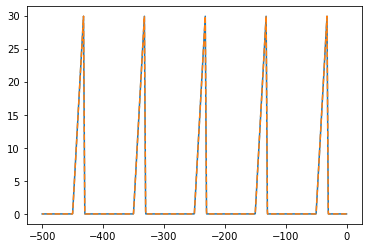

In [3]:
L_x, L_p, x2, x3, h = 500, 100, -32, -30, 30
x1 = -0.5*L_p
N_s = 1001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)

L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)
X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)



print("1d X error = ", np.linalg.norm(X0 - X.cpu().numpy()))
print("1d Y error = ", np.linalg.norm(Y0 - Y.cpu().numpy()))
X_Y_numpy = X_Y.cpu().numpy()
plt.plot(X0, Y0)
plt.plot(X_Y_numpy[0, :, 0], X_Y_numpy[0, :, 1], "--")

# ##################################################
# # Prediction on a special design
# #################################################
# model = torch.load("catheter_plain_period_model_1d500", map_location=device)
# out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()
# xx_mask = numpy.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)
# print("L_p, x1, x2, x3, h  = ", L_p, x1, x2, x3, h)
# print("loss = ",  -np.dot(out,xx_mask) )
# plt.figure()
# plt.plot(xx_mask, out)


[785.           5.03008     62.87507539 -31.43753769  -8.69985683
 -15.85508335  28.01017283]
sample =  785.0
min loss =  262913.0332581358 L_p, x2, x3, h =  tensor(62.8751) tensor(-8.6999) tensor(-15.8551) tensor(28.0102)
predicted loss:  266082.2155146275
-3169.1822564916583
0.24987506246876562


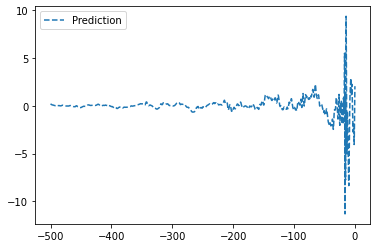

In [4]:
# All data design results
PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
n_data = 3000
inputX_raw = np.load(INPUT_X)[:, 0:n_data]
inputY_raw = np.load(INPUT_Y)[:, 0:n_data]
inputPara_raw = np.load(INPUT_para)[:, 0:n_data]
output_raw = np.load(OUTPUT)[:, 0:n_data]


# nx ny
L_x , N_s = 500.0, 2001

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0


n_data = inputX.shape[1]
all_loss = np.zeros(n_data)


for i in range(n_data):
    
    sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]
    xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
    all_loss[i] = -np.dot(output[:, i], xx_mask) * L_x/N_s

    

loss_min_ind = np.argmin(all_loss)
loss_min = all_loss[loss_min_ind]
sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]

model = torch.load("catheter_plain_length_model_1d500", map_location=device)
L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)

X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
out = torch.exp(model(X_Y).squeeze()).detach().cpu().numpy()


print(inputPara[:, loss_min_ind])
print("sample = ", sample)
print("min loss = ", loss_min, "L_p, x2, x3, h = ", L_p, x2, x3, h)

xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
print("predicted loss: ", -np.dot(out, xx_mask) * L_x/N_s)

density = output[:, loss_min_ind]
mesh_X = inputX[:, loss_min_ind]
mesh_Y = inputY[:, loss_min_ind]
plt.figure()
# plt.plot(xx_mask, density, label="Reference")
plt.plot(xx_mask, out - density, "--", label="Prediction")
# plt.plot(mesh_X, mesh_Y)
plt.legend()

print(np.dot(out - density, xx_mask) * L_x/N_s)
print(L_x/N_s)

# BFGS

1336001
initialize :  [ 1.32175584 -0.40546511  1.79175947  0.        ]
initialize :  (tensor(100., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<MulBackward0>), tensor(-40.0000, grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(25., grad_fn=<AddBackward0>))
L_p, x1, x2, x3, h  =  100.0 -50.0 -40.000003814697266 -30.0 25.0


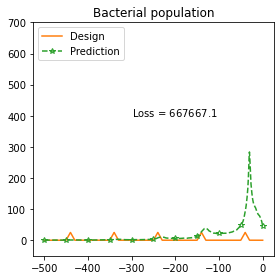

0 0.45572515903040767 loss =  644849.125 loss_min =  inf
L_p, x1, x2, x3, h  =  68.6058349609375 -34.30291748046875 -36.65972900390625 -16.566036224365234 25.33048439025879


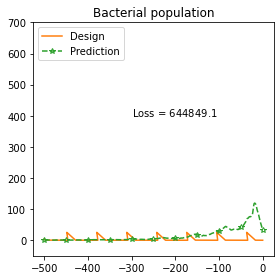

1 0.2291986090131104 loss =  656377.4375 loss_min =  644849.125
2 0.20668293721973896 loss =  485597.28125 loss_min =  644849.125
L_p, x1, x2, x3, h  =  83.38257598876953 -41.691287994384766 -18.41149139404297 -24.038108825683594 23.30562973022461


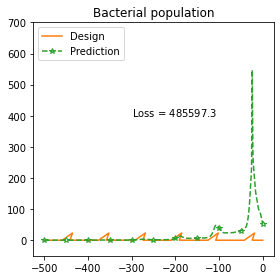

3 0.23314386000856757 loss =  659515.4375 loss_min =  485597.28125
4 0.23488016286864877 loss =  1121973.375 loss_min =  485597.28125
5 0.2185839433223009 loss =  464551.09375 loss_min =  485597.28125
L_p, x1, x2, x3, h  =  97.66375732421875 -48.831878662109375 -28.47418212890625 -26.65372657775879 26.90715789794922


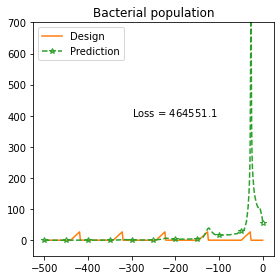

6 0.22809332981705666 loss =  1121827.625 loss_min =  464551.09375
7 0.23273474583402276 loss =  790023.375 loss_min =  464551.09375
8 0.198238261975348 loss =  447530.0625 loss_min =  464551.09375
L_p, x1, x2, x3, h  =  98.29824829101562 -49.14912414550781 -16.42548370361328 -29.430538177490234 28.924476623535156


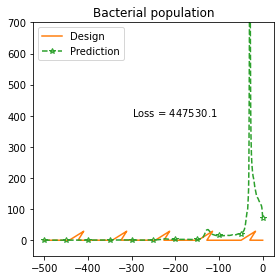

9 0.2110116737894714 loss =  376710.59375 loss_min =  447530.0625
L_p, x1, x2, x3, h  =  92.76156616210938 -46.38078308105469 -23.80535888671875 -12.682146072387695 28.64947509765625


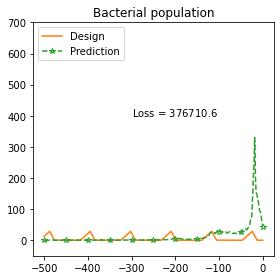

10 0.21436922019347548 loss =  420011.75 loss_min =  376710.59375
11 0.21319878427311778 loss =  384863.8125 loss_min =  376710.59375
12 0.21739675989374518 loss =  428196.15625 loss_min =  376710.59375
13 0.21669102739542723 loss =  336670.375 loss_min =  376710.59375
L_p, x1, x2, x3, h  =  64.92662048339844 -32.46331024169922 -16.227142333984375 -7.322836875915527 29.323467254638672


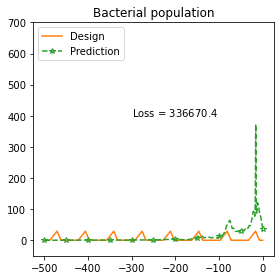

14 0.20599715365096927 loss =  763778.875 loss_min =  336670.375
15 0.19342367397621274 loss =  321739.125 loss_min =  336670.375
L_p, x1, x2, x3, h  =  80.35086822509766 -40.17543411254883 -11.795082092285156 -18.393152236938477 29.299678802490234


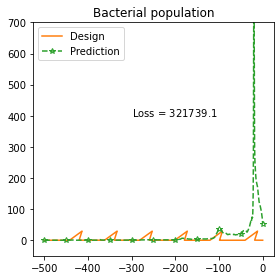

16 0.22981928894296288 loss =  545584.1875 loss_min =  321739.125
17 0.20905699720606208 loss =  376101.53125 loss_min =  321739.125
18 0.20562476199120283 loss =  294900.6875 loss_min =  321739.125
L_p, x1, x2, x3, h  =  65.48751831054688 -32.74375915527344 -23.37221908569336 -14.320714950561523 29.868804931640625


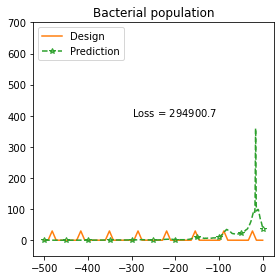

19 0.22149877389892936 loss =  519525.8125 loss_min =  294900.6875
20 0.2227326799184084 loss =  402911.90625 loss_min =  294900.6875
21 0.21404998004436493 loss =  544758.3125 loss_min =  294900.6875
22 0.21273080864921212 loss =  495430.84375 loss_min =  294900.6875
23 0.20763534493744373 loss =  333661.5 loss_min =  294900.6875
24 0.21457563573494554 loss =  276752.90625 loss_min =  294900.6875
L_p, x1, x2, x3, h  =  64.31825256347656 -32.15912628173828 -21.056907653808594 -13.345678329467773 29.92727279663086


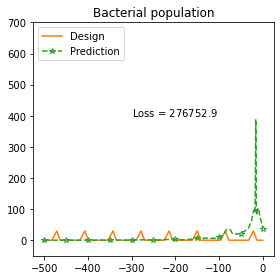

25 0.21016670810058713 loss =  366231.59375 loss_min =  276752.90625
26 0.20828134287148714 loss =  710279.0 loss_min =  276752.90625
27 0.2137022279202938 loss =  661994.3125 loss_min =  276752.90625
28 0.19415824674069881 loss =  234874.09375 loss_min =  276752.90625
L_p, x1, x2, x3, h  =  62.64595031738281 -31.322975158691406 -14.02346420288086 -11.936834335327148 29.974571228027344


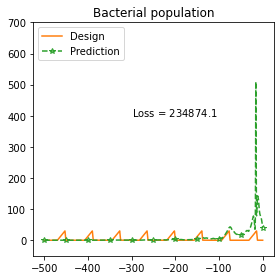

29 0.206136385910213 loss =  273026.0625 loss_min =  234874.09375
30 0.2075543189421296 loss =  256787.484375 loss_min =  234874.09375
31 0.21223850781098008 loss =  437935.21875 loss_min =  234874.09375
32 0.19342628493905067 loss =  289057.9375 loss_min =  234874.09375
33 0.18748910911381245 loss =  255227.796875 loss_min =  234874.09375
34 0.21366933407261968 loss =  314786.5 loss_min =  234874.09375
35 0.20918116718530655 loss =  508184.21875 loss_min =  234874.09375
36 0.21131196478381753 loss =  403081.90625 loss_min =  234874.09375
37 0.18917389120906591 loss =  278903.1875 loss_min =  234874.09375
38 0.12112819217145443 loss =  233281.25 loss_min =  234874.09375
L_p, x1, x2, x3, h  =  62.29357147216797 -31.146785736083984 -4.061698913574219 -15.413241386413574 29.933605194091797


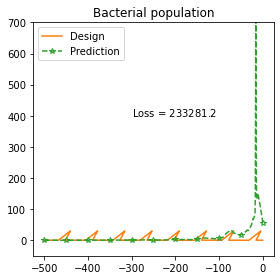

39 0.1917488961480558 loss =  255711.578125 loss_min =  233281.25
40 0.13311978289857507 loss =  265512.90625 loss_min =  233281.25
41 0.21111331740394235 loss =  248234.609375 loss_min =  233281.25
42 0.1296150111593306 loss =  249807.359375 loss_min =  233281.25
43 0.2052423171699047 loss =  242122.875 loss_min =  233281.25
44 0.13273799512535334 loss =  331589.84375 loss_min =  233281.25
45 0.11915245186537504 loss =  229406.203125 loss_min =  233281.25
L_p, x1, x2, x3, h  =  63.074947357177734 -31.537473678588867 -15.556453704833984 -15.409200668334961 29.96063232421875


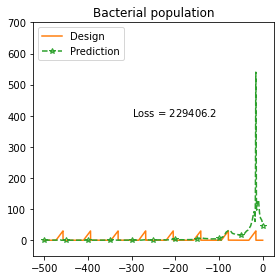

46 0.23434484377503395 loss =  577936.75 loss_min =  229406.203125
47 0.2201571580953896 loss =  343763.75 loss_min =  229406.203125
48 0.21832809690386057 loss =  652959.625 loss_min =  229406.203125
49 0.20607977267354727 loss =  256904.640625 loss_min =  229406.203125
50 0.20796013297513127 loss =  257708.8125 loss_min =  229406.203125
51 0.1320575838908553 loss =  268390.5625 loss_min =  229406.203125
52 0.192829682957381 loss =  265124.9375 loss_min =  229406.203125
53 0.18173854472115636 loss =  232890.75 loss_min =  229406.203125
54 0.13172446098178625 loss =  233407.015625 loss_min =  229406.203125
55 0.1174113699235022 loss =  263565.5625 loss_min =  229406.203125
56 0.1899512126110494 loss =  260976.109375 loss_min =  229406.203125
57 0.18695925502106547 loss =  297237.34375 loss_min =  229406.203125
58 0.20067045418545604 loss =  512399.3125 loss_min =  229406.203125
59 0.20698399003595114 loss =  404838.40625 loss_min =  229406.203125
60 0.20817124098539352 loss =  362029.8

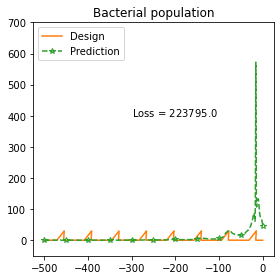

66 0.11468042200431228 loss =  322003.53125 loss_min =  223794.953125
67 0.17109820572659373 loss =  290883.125 loss_min =  223794.953125
68 0.10349138686433434 loss =  230319.8125 loss_min =  223794.953125
69 0.11581364087760448 loss =  256676.734375 loss_min =  223794.953125
70 0.10385364992544055 loss =  291990.15625 loss_min =  223794.953125
71 0.11527512688189745 loss =  292591.53125 loss_min =  223794.953125
72 0.1170863350853324 loss =  274120.1875 loss_min =  223794.953125
73 0.10142341908067465 loss =  278863.84375 loss_min =  223794.953125
74 0.1208015289157629 loss =  287564.125 loss_min =  223794.953125
75 0.18455865234136581 loss =  395127.125 loss_min =  223794.953125
76 0.1050032819621265 loss =  262773.125 loss_min =  223794.953125
77 0.08602414792403579 loss =  237119.953125 loss_min =  223794.953125
78 0.10097581194713712 loss =  236516.4375 loss_min =  223794.953125
79 0.11428644508123398 loss =  239293.890625 loss_min =  223794.953125
80 0.11955168889835477 loss =  

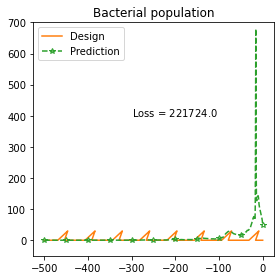

102 0.2039872519671917 loss =  235321.359375 loss_min =  221724.03125
103 0.11677353922277689 loss =  262885.5 loss_min =  221724.03125
104 0.20357464905828238 loss =  368782.28125 loss_min =  221724.03125
105 0.22162006981670856 loss =  240459.765625 loss_min =  221724.03125
106 0.20597939658910036 loss =  224705.203125 loss_min =  221724.03125
107 0.1943438951857388 loss =  224144.109375 loss_min =  221724.03125
108 0.10816784529015422 loss =  231060.671875 loss_min =  221724.03125
109 0.10967142460867763 loss =  239961.15625 loss_min =  221724.03125
110 0.12419617595151067 loss =  308150.09375 loss_min =  221724.03125
111 0.1925958599895239 loss =  241909.953125 loss_min =  221724.03125
112 0.12229669699445367 loss =  263647.9375 loss_min =  221724.03125
113 0.09629003005102277 loss =  257023.828125 loss_min =  221724.03125
114 0.10347060719504952 loss =  247240.25 loss_min =  221724.03125
115 0.09599569533020258 loss =  284223.15625 loss_min =  221724.03125
116 0.09268760867416859 

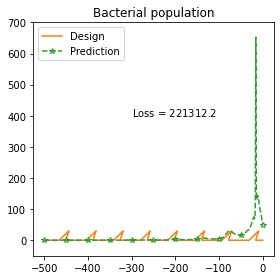

124 0.10812901891767979 loss =  455780.71875 loss_min =  221312.21875
125 0.09190738806501031 loss =  236295.015625 loss_min =  221312.21875
126 0.11238429509103298 loss =  317643.1875 loss_min =  221312.21875
127 0.1039143493399024 loss =  279372.0 loss_min =  221312.21875
128 0.0943635730072856 loss =  256050.421875 loss_min =  221312.21875
129 0.09567937208339572 loss =  242719.921875 loss_min =  221312.21875
130 0.11345337331295013 loss =  280027.09375 loss_min =  221312.21875
131 0.09183657867833972 loss =  314572.0 loss_min =  221312.21875
132 0.09079195000231266 loss =  229357.65625 loss_min =  221312.21875
133 0.11197363492101431 loss =  232454.421875 loss_min =  221312.21875
134 0.12264263583347201 loss =  257845.046875 loss_min =  221312.21875
135 0.12006138172000647 loss =  326834.09375 loss_min =  221312.21875
136 0.10865109600126743 loss =  267899.96875 loss_min =  221312.21875
137 0.07584120193496346 loss =  234976.609375 loss_min =  221312.21875
138 0.0776736019179225 lo

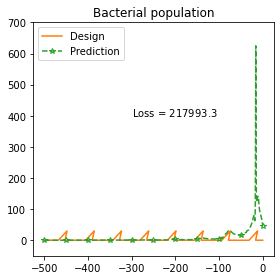

160 0.06279423786327243 loss =  227390.984375 loss_min =  217993.265625
161 0.08907629689201713 loss =  229482.921875 loss_min =  217993.265625
162 0.09359513176605105 loss =  312066.5 loss_min =  217993.265625
163 0.07985711516812444 loss =  253674.84375 loss_min =  217993.265625
164 0.09314987109974027 loss =  228205.578125 loss_min =  217993.265625
165 0.07695179060101509 loss =  231103.734375 loss_min =  217993.265625
166 0.07812133291736245 loss =  231121.296875 loss_min =  217993.265625
167 0.06445862399414182 loss =  304906.125 loss_min =  217993.265625
168 0.07704164599999785 loss =  221516.953125 loss_min =  217993.265625
169 0.06016487115994096 loss =  263572.71875 loss_min =  217993.265625
170 0.07865704502910376 loss =  274837.78125 loss_min =  217993.265625
171 0.06126144016161561 loss =  291761.09375 loss_min =  217993.265625
172 0.06493322271853685 loss =  243018.65625 loss_min =  217993.265625
173 0.0629803529009223 loss =  302529.875 loss_min =  217993.265625
174 0.062

In [22]:
################################################################
# inverse optimization for 1d
################################################################
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

model = torch.load("catheter_plain_length_model_1d1000", map_location=device)
print(count_params(model))


epochs = 250

# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/2
#             -L_p < x2      < 0
#               20 < h       < 30
# def transfer(theta):
def transfer(theta):
    
    L_p = 60 + (250 - 60)/(1 + torch.exp(theta[0]))
    x1 = -0.5*L_p
    x3 = x1  + 15 + (L_p/2 - 15)/(1 + torch.exp(theta[2]))
    x2 = -L_p  + L_p/(1 + torch.exp(theta[1]))
    h = 20   + (10)/(1 + torch.exp(theta[3]))
    return L_p, x1, x2, x3, h


def inv_transfer(L_p, x2, x3, h):
    x1 = -0.5*L_p
    theta = np.zeros(4)
    theta[0] = np.log( (250 - 60)/(L_p - 60) - 1 )
    theta[1] = np.log( L_p/(x2 + L_p) - 1 )
    theta[2] = np.log( (L_p/2 - 15)/(x3 - x1  - 15) - 1 )
    theta[3] = np.log( 10/(h - 20 ) - 1 )
    return theta

# sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]
# L_p, x2, x3, h = 80.0, -22.0, -22.0, 28.0
L_p, x2, x3, h = 100.0, -40.0, -30.0, 25.0
# L_p, x2, x3, h = 61.0, -30.0, -12.5, 29.0
# x2, x3, h = 73.85438537597656, -9.479606628417969, -19.35201644897461, 27.60188102722168
theta0 =  inv_transfer(L_p, x2, x3, h) 
print("initialize : ", theta0)

theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)
print("initialize : ", transfer(theta))

bacteria_pred = []
L_x = 500
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)

max_iter = 100

optimizer = torch.optim.LBFGS([theta], max_iter=max_iter, lr=1.0, line_search_fn="strong_wolfe")

loss_min = torch.tensor(np.inf)

loss_all = []
theta_min = torch.clone(theta)

def saveplot(theta, out, savefig_name):
    bacteria_pred.append(out)
    L_p, x1, x2, x3, h = transfer(theta)
    mesh = x.detach().cpu().numpy()
    
    current_loss = (-torch.sum(torch.matmul(out, xx_mask))* L_x/N_s).item()
    
    print("L_p, x1, x2, x3, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), h.item())
    plt.figure(figsize=(4,4))
    plt.title("Bacterial population")
    plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="C1", label="Design")
    plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "--*", color="C2", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
    
    plt.legend(loc="upper left")
    plt.ylim([-50,700])
    
    plt.text(-300,400,"Loss = "+r"$%3.1f$" %current_loss,\
          bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1})
    
    
    plt.tight_layout()
    plt.savefig(savefig_name)
    plt.show()
    
plot_id = 0

# first_figure
L_p, x1, x2, x3, h = transfer(theta)  
x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
out = torch.exp(model(x).squeeze())
saveplot(theta, out, "movie/design_iter" + str(plot_id).zfill(4) + ".png")
plot_id += 1

for ep in range(epochs):
    t1 = default_timer()
    def loss_closure():
        
        L_p, x1, x2, x3, h = transfer(theta)
        
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
    
        optimizer.zero_grad()
        out = torch.exp(model(x).squeeze())
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        loss.backward()
        loss_all.append(loss.item())
        return loss
    
    
    optimizer.step(loss_closure)

    t2 = default_timer()
 
    if ep%1==0:
        
        L_p, x1, x2, x3, h = transfer(theta)
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
        out = torch.exp(model(x).squeeze())
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        print(ep, t2 - t1,  "loss = ", loss.item(), "loss_min = ", loss_min.item(),)
 
        if loss < loss_min:
            
            theta_min = torch.clone(theta)
            loss_min = loss
            
            
            saveplot(theta, out, "movie/design_iter"+ str(plot_id).zfill(4)+".png")
            plot_id += 1
            
        theta = theta_min + torch.normal(mean=0.0, std=torch.ones(len(theta)))

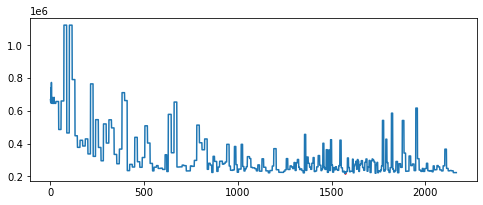

In [50]:
fig = plt.figure(figsize=(8,3))
plt.plot(loss_all, "-", markersize=1)
minind = np.array(loss_all).argmin()
plt.scatter(minind, loss_all[minind], color="red", s=2)
fig.savefig("optimization-loss.pdf")

1570

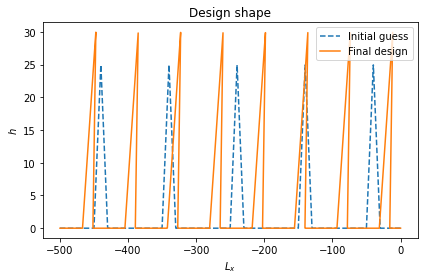

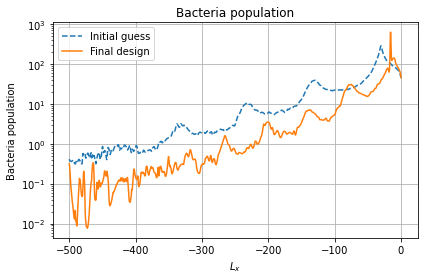

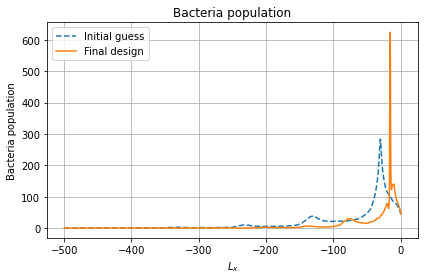

In [10]:
# Draw initial guess and final designs 

L_x, L_p, x2, x3, h = 500, 100.0, -40.0, -30.0, 25.0
x1 = -0.5*L_p
N_s = 2001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
plt.figure(figsize=(6, 4))
plt.plot(X0, Y0, "--", label="Initial guess")
L_p, x1, x2, x3, h = 62.2564697265625,  -31.12823486328125, -11.565677642822266, -15.864848136901855, 29.99827766418457
x1 = -0.5*L_p
N_s = 2001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
plt.plot(X0, Y0, label="Final design")
plt.legend()
plt.title("Design shape")
plt.ylabel("$h$")
plt.xlabel("$L_x$")
plt.tight_layout()
plt.savefig("design.png")


xx_mask = np.linspace(1.0, 0, N_s) * (-L_x)
#######################################################################
plt.figure(figsize=(6, 4))
plt.plot(xx_mask, bacteria_pred[0].detach().cpu().numpy(), "--", label="Initial guess")
plt.semilogy(xx_mask, bacteria_pred[-1].detach().cpu().numpy(), label="Final design")
plt.legend()
plt.title("Bacteria population")
plt.grid("on")
plt.ylabel("Bacteria population")
plt.xlabel("$L_x$")
plt.tight_layout()
plt.savefig("bacteria_population_semilogy.png")


#######################################################################
plt.figure(figsize=(6, 4))
plt.plot(xx_mask, bacteria_pred[0].detach().cpu().numpy(), "--", label="Initial guess")
plt.plot(xx_mask, bacteria_pred[-1].detach().cpu().numpy(), label="Final design")
plt.legend()
plt.title("Bacteria population")
plt.grid("on")
plt.ylabel("Bacteria population")
plt.xlabel("$L_x$")
plt.tight_layout()
plt.savefig("bacteria_population.png")

data/tri1_U020uf5alpha1.5tauR2_19.5626_15.2634_29.9983.h5old.h5
data/tri1_U020uf15alpha1.5tauR2_19.5626_15.2634_29.9983.h5
data/tri1_U020uf10alpha1.5tauR2_19.5626_15.2634_29.9983.h5
fno_loss =  218137.71875 ref_loss =  218837.35233834037


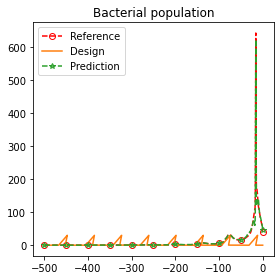

In [11]:
import glob
# Design validation

train_data_folder = "data"
t = 9


N_s, L_x = 2001, 500
bw_method = 1e-1
xx = np.linspace(-L_x, 0.0, N_s)
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)

samples = [0]
x_mesh, y_mesh = np.zeros((len(samples), N_s)), np.zeros((len(samples), N_s))
density_1d_data_all = np.zeros((len(samples), N_s, 3))
density_1d_data = np.zeros((len(samples), N_s))
L_p, x1, x2, x3, h = 62.2564697265625,  -31.12823486328125, -11.565677642822266, -15.864848136901855, 29.99827766418457
# L_p, x1, x2, x3, h = 62.32211685180664, -31.16105842590332, -11.533348083496094, -16.148033142089844, 29.966632843017578

for i in range(len(samples)):
    
    x_mesh[i,:], y_mesh[i,:] = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
    
    file_names = glob.glob(train_data_folder+"/tri*")
    for file_name in file_names:
        
        print(file_name)
        uf  = np.float64(  file_name[file_name.find("uf") + len("uf"):  file_name.find("alpha")]  )
        # sample is from 1 - 1000
        j = 0
        if uf < (5.0 + 10.0)/2:
            j = 0
        elif uf < (10. + 15.0)/2:
            j = 1
        elif uf < (15. + 20.0)/2:
            j = 2
        else:
            print("error! uf = ", uf)
            
        
        # preprocee density
        hf = h5py.File(file_name, "r")
        x_b = hf["config"][str(t+1)]["x"][:]
        y_b = hf["config"][str(t+1)]["y"][:]

        if(min(x_b) < -L_x):
            print("warning: bacteria out of the domain. file_name = ", file_name, " loc = ", min(x_b), " end point = ", -L_x)

        

        bacteria_1d_data = x_b[np.logical_and(x_b <= 0 , x_b >= -L_x)]
        n_particle = len(bacteria_1d_data)
        kernel = stats.gaussian_kde(bacteria_1d_data, bw_method = bw_method)
        density_1d_data_all[i, :, j] = kernel(xx)*n_particle
    
    density_1d_data[i, :] = np.mean(density_1d_data_all[i, :, :], axis=1)

    plt.figure(figsize=(4,4))
    plt.plot(xx,  density_1d_data[i, :], "--o", color="red", markevery=len(xx_mask)//10, fillstyle='none', label="Reference")
    plt.plot(x_mesh[i, :], y_mesh[i, :], color="C1", label="Design")
    
    ref_loss = -np.sum(np.matmul(density_1d_data[i, :], xx))* L_x/N_s
    

    x, XC, YC = catheter_mesh_1d_total_length(L_x, torch.tensor(L_p), torch.tensor(x2), torch.tensor(x3), h, N_s)
    out = torch.exp(model(x).squeeze())
    fno_loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
    print("fno_loss = ", fno_loss.item(), "ref_loss = ", ref_loss)
        
    plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "--*", color="C2", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
    plt.legend()
    plt.title("Bacterial population")
    plt.tight_layout()
    plt.savefig("Design_tri.pdf")



# Plot 

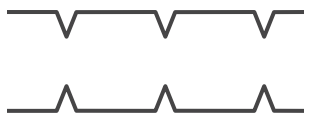

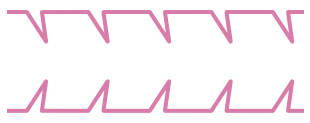

In [50]:
# Draw initial guess and final designs 

L_x, L_p, x2, x3, h = 500, 100.0, -40.0, -30.0, 25.0
x1 = -0.5*L_p
N_s = 2001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
plt.figure(figsize=(6, 2))
plt.plot(X0, 100-Y0, color="#464546", linewidth=4.0)
plt.plot(X0, Y0, color="#464546", linewidth=4.0)
plt.axis('off'),
plt.xlim([-300, 0])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig("initial_guess.pdf")

L_p, x1, x2, x3, h = 62.2564697265625,  -31.12823486328125, -11.565677642822266, -15.864848136901855, 29.99827766418457
x1 = -0.5*L_p
N_s = 2001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
plt.figure(figsize=(6, 2))
plt.plot(X0, 100-Y0, color="#D87CA9", linewidth=4.0)
plt.plot(X0, Y0, color="#D87CA9", linewidth=4.0)
plt.axis('off'),
plt.xlim([-300, 0])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig("final_guess.pdf")
# plt.title("Design shape")
# plt.ylabel("$h$")
# plt.xlabel("$L_x$")
# plt.savefig("design.png")




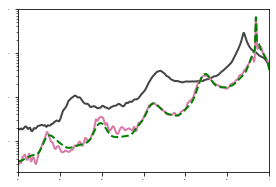

In [37]:
xx_mask = np.linspace(1.0, 0, N_s) * (-L_x)
#######################################################################
plt.figure(figsize=(4.5, 3))
plt.plot(xx_mask, bacteria_pred[0].detach().cpu().numpy(), color="#464546", linewidth=2.0, label="initial design")
plt.semilogy(xx_mask, bacteria_pred[-1].detach().cpu().numpy(), color="#D87CA9", linewidth=2.0, label="optimized design")
plt.semilogy(xx_mask, density_1d_data[i, :], "--",  color="green", linewidth=2.0)

plt.xlim([-300, 0])
plt.ylim([0.2, 1e3])
#plt.grid(linestyle='--', linewidth=0.5)


# plt.legend(loc = "upper center",bbox_to_anchor=(0.5,1.15),ncol=2)
# plt.tight_layout()
plt.tick_params(labelsize=0) 
# plt.yticks(labelsize=0) 
plt.savefig("bacteria_population_semilogy.pdf")




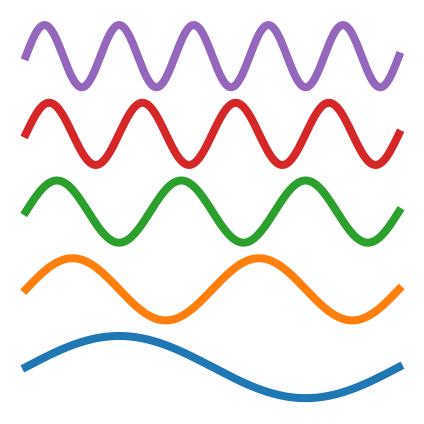

In [54]:
# Draw Fourier basis functions

xx = np.linspace(0, 1, 1001)

plt.figure(figsize=(6, 6))
dy = 2.5
shift = 0
for i in range(5):
    plt.plot(xx, np.sin(2*np.pi*(i+1)*xx)+shift*dy, color="C"+str(i),  linewidth=8.0)
    shift += 1.0
#     plt.plot(xx, np.cos(2*np.pi*(2*i+2)*xx)+shift*dy,   linewidth=4.0)
#     shift += 1.0
plt.axis('off'),
# ax = plt.gca()
# # ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig("Fourier_basis_functions.pdf")



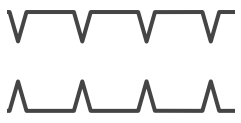

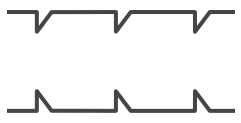

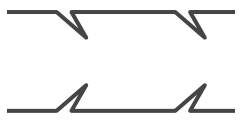

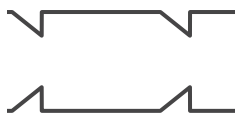

In [5]:
L_x = 500
L_ps = [65, 80, 120, 150]
x2s = [-L_ps[0]/2+ 8.5, -L_ps[1]/2, -L_ps[2]/2 + 30.0, -L_ps[3]/2 + 30.0]
x3s = [-L_ps[0]/2 + 17.0, -L_ps[1]/2 + 15, -L_ps[2]/2 + 15.0, -L_ps[3]/2 + 30.0]

hs = [29.9, 20, 26, 24]
for i in range(4):
    L_p = L_ps[i] 
    x1 = -L_p/2.0
    x2, x3 = x2s[i], x3s[i]
    h = hs[i]

    N_s = 2001
    X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
    plt.figure(figsize=(6, 2))
    plt.plot(X0, 100-Y0, color="#464546", linewidth=4.0)
    plt.plot(X0, Y0, color="#464546", linewidth=4.0)
    plt.axis('off'),
    plt.xlim([-230, 0])
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.savefig("design_data_"+str(i)+".pdf")

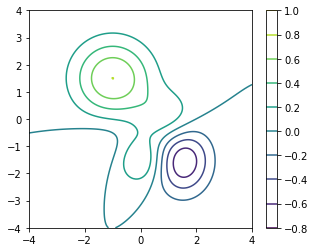

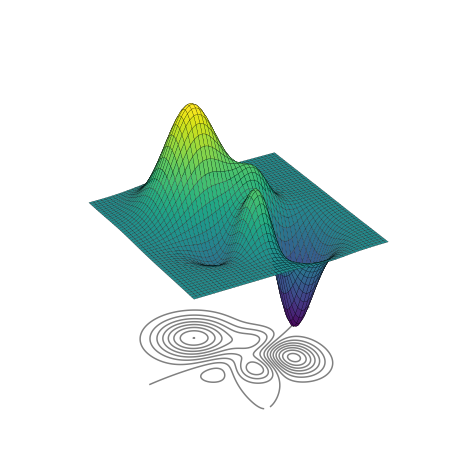

In [131]:
def Gaussian_helper(x, m, C):
    return np.exp(-0.5*np.dot(x - m , np.linalg.solve(C,x - m)))
    
def Gaussian(X, Y, m, C):
    nx, ny = X.shape
    Z = np.zeros((nx, ny))
    for ix in range(nx):
        for iy in range(ny):
            Z[ix, iy] = Gaussian_helper(np.array([X[ix, iy], Y[ix, iy]]), m, C)
    return Z

nx, ny = 200, 200
xx = np.linspace(-4, 4, nx)
yy = np.linspace(-4, 4, ny)
X, Y = np.meshgrid(xx ,yy)


Z = np.zeros((nx, ny))
Z += 0.8*Gaussian(X, Y, np.array([-1.0, 1.5]), np.array([[1.0, 0.0], [0.0, 1.0]]))
Z += 0.4*Gaussian(X, Y, np.array([1.0, 0.0]), np.array([[0.5, 0.0], [0.0, 0.5]]))
Z += 0.5*Gaussian(X, Y, np.array([0.0, -1.5]), np.array([[0.4, 0.0], [0.0, 0.4]]))
Z += -0.2*Gaussian(X, Y, np.array([-1.2, -1.0]), np.array([[0.8, 0.0], [0.0, 0.5]]))
Z += -0.8*Gaussian(X, Y, np.array([1.5, -1.5]), np.array([[0.5, 0.0], [0.0, 0.8]]))

plt.figure(figsize=(5,4))
# plt.pcolormesh(X, Y, Z)
plt.contour(X, Y, Z)
plt.colorbar()


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis", lw=0.2, linestyles="solid", edgecolors='k', rstride=4, cstride=4)
# # ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
ax.contour(X, Y, Z, 15, colors="grey", linestyles="solid", offset=-1.0)
# ax.set_xlabel("x")
ax.set_axis_off()
# ax.set(zlim=(-0.5, 2))
ax.view_init(30, -120)
fig.savefig("optimization.pdf")
# fig = plt.figure(figsize=(4,3))
# ax = fig.add_subplot(111, projection='3d')

# # Z += np.sin(np.pi*X)*np.sin(np.pi*Y)
# ax.plot_surface(X, Y, Z, cmap="viridis", lw=0.1, rstride=1, cstride=1)
# # # ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
# ax.contour(X, Y, Z, 10, colors="k", linestyles="solid", offset=-0.5)

# ax.set_axis_off()
# ax.set(zlim=(-0.5, 2))
# # ax.view_init(30, 30)
# plt.show()


# fig.axes.get_xaxis().set_visible(False)
# fig.axes.get_yaxis().set_visible(False)
# fig.axes.get_zaxis().set_visible(False)
# 
# # ax.set_xticks([0, -30, -60])
# ax.tick_params(axis='x', which='major', pad=-4)
# ax.set_xlabel(r"$x_2$", labelpad=-5)
# # ax.set_yticks([0, -8, -16])
# ax.tick_params(axis='y', which='major', pad=-4)

# ax.set_ylabel(r"$x_3$", labelpad=-5)
# # ax.set_zticks([3e5, 6e5, 9e5])
# ax.tick_params(axis='z', which='major', pad=-4)

# # ax.ticklabel_format(axis='z', style='scientific',  scilimits=(1,4), useMathText=True)
# fig.tight_layout()
# fig.savefig("landscape-1.pdf")

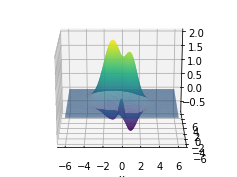

In [87]:

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis", lw=0.0, rstride=1, cstride=1)
# # ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
# ax.contour(X, Y, Z, 10, colors="k", linestyles="solid", offset=-0.5)
ax.set_xlabel("x")
# ax.set_axis_off()
# ax.set(zlim=(-0.5, 2))
ax.view_init(20, -90)
plt.show()

/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'lw'
  # Remove the CWD from sys.path while we load stuff.
/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'lw'
  # This is added back by InteractiveShellApp.init_path()


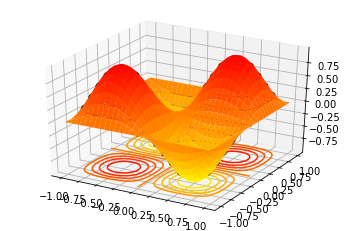

In [90]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, Y = np.mgrid[-1:1:30j, -1:1:30j]
Z = np.sin(np.pi*X)*np.sin(np.pi*Y)
ax.plot_surface(X, Y, Z, cmap="autumn_r", lw=0.5, rstride=1, cstride=1)
ax.contour(X, Y, Z, 10, lw=3, cmap="autumn_r", linestyles="solid", offset=-1)
ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
plt.show()

/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The following kwargs were not used by contour: 'lw'
  


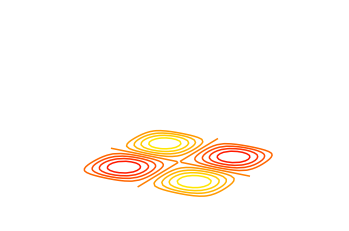

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, Y = np.mgrid[-1:1:30j, -1:1:30j]
Z = np.sin(np.pi*X)*np.sin(np.pi*Y)
# ax.plot_surface(X, Y, Z, cmap="viridis", lw=0.0, rstride=1, cstride=1)
ax.contour(X, Y, Z, 10, lw=3, cmap="autumn_r", linestyles="solid", offset=-1)
ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
ax.set_axis_off()
plt.show()